Preparing the Data for a Time Series Analysis
==========================

## Using NOAA's API
For this project, I will be using the National Oceanic and Atmospheric Administration (NOAA) API to pull five different weather-related attributes. 
Max Temperature, Min Temperature, Precipitation, Snowfall, and Windspeed.
Accessing this data requires a specific station ID and a valid API token, which can be obtained from NOAA's data service. We will start with the last 38 years of weather data and work from there.


In [ ]:
import requests
import json
from time import sleep

In [17]:
# Define the station, years, data types, and header
station_id = 'GHCND:USW00026451'
years = range(1985, 2023)
data_types = 'TMAX,TMIN,PRCP,SNOW,AWND'
headers = {'token': 'YOUR TOKEN GOES HERE'}

Station IDs are retrievable via the NOAA API by providing the relevant State FIPS ID (Federal Information Processing Standard), the name of the city, and the API token. FIPS IDs are systematic codes assigned to U.S. geographic entities and can be easily accessed through the 'us' library.

In [18]:
def get_all_fips():
    fips_codes = {}
    for state in us.STATES:
        fips_codes[state.name] = state.fips
    for state, fips in fips_codes.items():
        print(f"{state}: {fips}")

In [19]:
def fetch_station_ids(city, state, token):
    url = "https://www.ncdc.noaa.gov/cdo-web/api/v2/stations"
    headers = {"token": token}
    params = {"locationid": f"FIPS:{state}", "limit": 1000}  # You can adjust the limit as needed
    response = requests.get(url, headers=headers, params=params)

    if response.status_code != 200:
        print(f"Failed to get data: {response.status_code}")
        return

    data = response.json()
    city_stations = []
    for station in data.get('results', []):
        if city.lower() in station.get('name', '').lower():
            station_info = {'id': station['id'], 'name': station['name']}
            city_stations.append(station_info)
    for station_info in city_stations:
        print(f"ID: {station_info['id']}, Location: {station_info['name']}")

fetch_station_ids('Anchorage', '02', 'YOUR TOKEN GOES HERE')

Failed to get data: 400


Now we can start pulling the weather data. I ran into a problem originally where only the first seven months were being pulled.
There is a limit on how much you can pull at once from NOAA. So to combat this, we will split the data in half.

In [25]:
first_half = [(f"{year}-01-01", f"{year}-06-30") for year in years]
second_half = [(f"{year}-07-01", f"{year}-12-31") for year in years]
all_ranges = list(zip(first_half, second_half))

In [24]:
def pull_weather_data():
    for (start1, end1), (start2, end2) in all_ranges:
        all_data = []

        for start, end in [(start1, end1), (start2, end2)]:
            base_url = "https://www.ncdc.noaa.gov/cdo-web/api/v2/data"
            params = {
                'stationid': station_id,
                'datasetid': 'GHCND',
                'startdate': start,
                'enddate': end,
                'datatypeid': data_types,
                'limit': 1000
            }
            response = requests.get(base_url, headers=headers, params=params)

            # In case of error
            if response.status_code == 200:
                data = response.json().get('results', [])
                all_data.extend(data)
            else:
                print(f"Failed to get data for {start} to {end}")

            # Wait for a second before the next API request to avoid rate-limiting
            sleep(1)

        # Save the data to a separate JSON file for each year
        year = start1.split("-")[0]
        filename = f'anchorage_weather_data_{year}.json'
        with open(filename, 'w') as f:
            json.dump(all_data, f)
        print(f"Saved data to {filename}")

To make it easier to find potential errors, the data gets saved in a new file for every year. 
Next we will do some unit conversion and convert all the jsons into one cvs fill for easier access. 

## Converting and Combining
The JSON files aren't in the most user-friendly format. First, we will rename the columns, and then we will convert the units to imperial.
We will also remove the 'attributes' and 'station' columns since we do not need them. Finally we will combine them all into one
CSV file.

In [ ]:
import json
import pandas as pd
from pathlib import Path

In [ ]:
# Function to convert temperature from tenths of degrees C to F
def convert_temp_to_fahrenheit(temp_in_tenths_c):
    temp_in_c = temp_in_tenths_c / 10
    return (temp_in_c * 9/5) + 32

# Function to convert precipitation and snowfall from tenths of mm to inches
def convert_precip_and_snow_to_inches(precip_in_tenths_mm):
    precip_in_mm = precip_in_tenths_mm / 10
    return precip_in_mm * 0.0393701

# Function to convert wind speed from m/s to mph
def convert_wind_speed_to_mph(wind_speed_in_ms):
    return wind_speed_in_ms * 2.23694

# Function to process and clean a single JSON file
def process_json_file(json_file_path):
    with open(json_file_path, 'r') as f:
        data = json.load(f)

    df = pd.DataFrame(data)
    df.drop(columns=['attributes', 'station'], inplace=True)

    # Rename columns for better readability
    df.rename(columns={
        'datatype': 'DataType',
        'date': 'Date',
        'value': 'Value',
        'AWND': 'Windspeed',
        'PRCP': 'Precipitation',
        'SNOW': 'Snowfall',
        'TMAX': 'Temperature_Max',
        'TMIN': 'Temperature_Min'
    }, inplace=True)

    # Convert to imperial measurments
    df.loc[df['DataType'] == 'Temperature_Max', 'Value'] = df[df['DataType'] == 'Temperature_Max']['Value'].apply(convert_temp_to_fahrenheit)
    df.loc[df['DataType'] == 'Temperature_Min', 'Value'] = df[df['DataType'] == 'Temperature_Min']['Value'].apply(convert_temp_to_fahrenheit)
    df.loc[df['DataType'] == 'Precipitation', 'Value'] = df[df['DataType'] == 'Precipitation']['Value'].apply(convert_precip_and_snow_to_inches)
    df.loc[df['DataType'] == 'Snowfall', 'Value'] = df[df['DataType'] == 'Snowfall']['Value'].apply(convert_precip_and_snow_to_inches)
    df.loc[df['DataType'] == 'Windspeed', 'Value'] = df[df['DataType'] == 'Windspeed']['Value'].apply(convert_wind_speed_to_mph)

    return df

This function is run through the 'combine_json_to_csv' function.

In [ ]:
def combine_json_to_csv(folder_path, output_csv_path):

    # Create a Path object for the folder containing JSON files and list all JSON files
    folder = Path(folder_path)
    json_files = [f for f in folder.glob("*.json")]
    all_data_frames = []

    # Loop through each JSON file
    for json_file in json_files:

        # Process each json file into a datafram and append to list
        df = process_json_file(json_file)
        if df is not None:
            all_data_frames.append(df)

    # Concatenate all the DataFrames, pivot to get DataType as columns, save to CSV
    combined_df = pd.concat(all_data_frames)
    pivot_df = combined_df.pivot(index='Date', columns='DataType', values='Value')
    pivot_df = pivot_df.round(2)
    pivot_df.to_csv(output_csv_path)

folder_path = 'json_file_set_38_years'
output_csv_path = "Anchorage_weather_38_years.csv"
combine_json_to_csv(folder_path, output_csv_path)

Now all the json files are cleaned and combined into a single csv file. On another note, while running the actual SARIMA model i discovered that working with days was much to labor intensive for my computer. Changing it to weeks made the data more manageable, and I was pleased with the results, although daily data would likely yield more detailed insights.

In [ ]:
# Load the dataset
df = pd.read_csv('Anchorage_weather_38_years.csv')

# Convert the 'Date' column to datetime format and set it as the index
df = pd.read_csv('Anchorage_weather_38_years.csv')

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Resample the data to weekly frequency, taking the mean for each week
df_weekly = df.resample('W').mean().round(2)

# Save the weekly data to a new CSV file
df_weekly.to_csv('Anchorage_weather_38_years_weekly.csv')

## Graphing the Data
Graphing the data will provide a better understanding of the trends and reveal any obvious outliers to be wary of.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
df = pd.read_csv('CSV/Anchorage_weather_38_years_weekly.csv')

# Convert the 'Date' column to a datetime object and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Plot the time series data for TMAX_F
plt.figure(figsize=(15, 6))
plt.plot(df['Temperature_Max'], label='Temperature_Max (°F)', color='b')

# Add horizontal lines at intervals of 20 degrees
for temp in range(-20, 100, 20):
    plt.axhline(y=temp, color='gray', linestyle='--', linewidth=0.5)

# Add vertical lines at intervals of 5 years
for year in range(2018, 2022 + 1, 5):
    plt.axvline(pd.Timestamp(f'{year}-01-01'), color='gray', linestyle='--', linewidth=0.5)

plt.title('Five years of Maximum Temperature in Anchorage')
plt.xlabel('Date')
plt.ylabel('Temperature (°F)')
plt.legend()
plt.show()

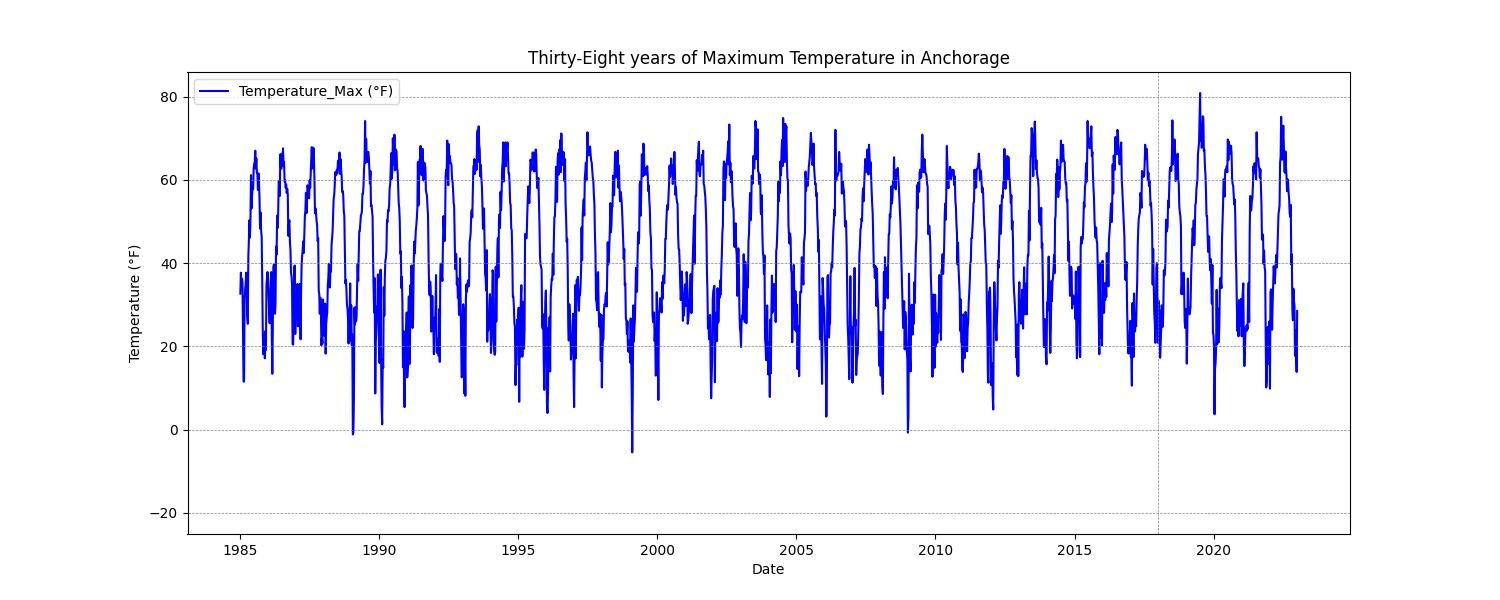

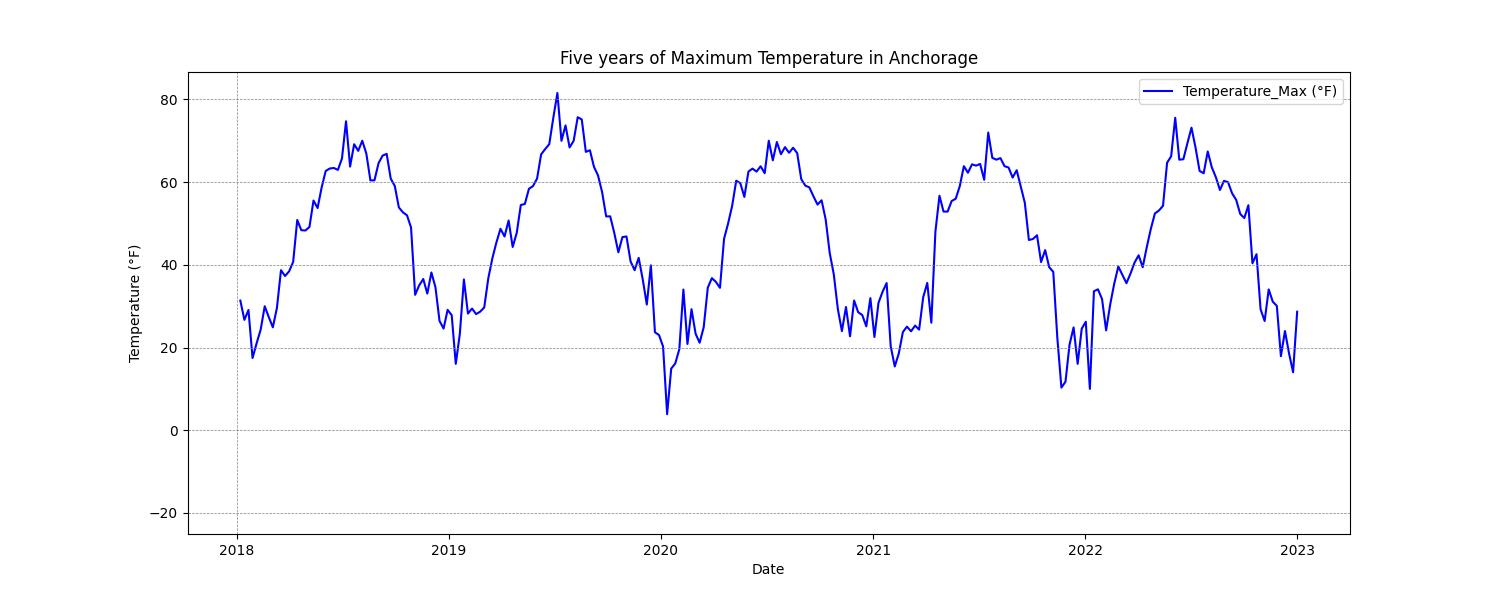

With the graph, we can see that temperatures look relativly consistant. 
However, if we examine the last five years, we can observe a peak right before the pandemic followed by an understandable dip afterward. Since using all thirty-eight years of data would be too labor-intensive
I will focus on the last five years of data

## ADF and PACF tests
"Before we commence the SARIMA model testing, we should run some preliminary tests to check for stationarity, which will assist us in selecting our initial SARIMA parameters. The first test is the Augmented Dickey-Fuller test to test stationarity.

Stationarity is a property of a time series in which its statistical properties do not change over time. In other words, a stationary time series will have constant mean, variance, and autocorrelation. Our data looks relatively constant over time, so we should expect stationarity. Non stationary data could be affected by long term upward or downward trends, a multi year drought, or unusually large or unexpected weather systems.

In [ ]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

In [ ]:
df = pd.read_csv('CSV/Anchorage_weather_5_years_weekly.csv')

# Function to perform Augmented Dickey-Fuller test
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')

    # Create labels and a pandas series to store test results
    labels = ['ADF Test Statistic', 'p-value', 'Number of lags used', 'Number of observations']
    out = pd.Series(result[0:4], index=labels)

    # Append critical values to the output Series
    for key, val in result[4].items():
        out[f'Critical Value ({key})'] = val
    print(out.to_string())

    if result[1] <= 0.05:
        print("Data has no unit root and is stationary")
    else:
        print("Time series has a unit root, indicating it is non-stationary")


# Check stationarity for Maximum Temperature
adf_test(df['Temperature_Max'], title='Temperature_Max')

In [ ]:
Augmented Dickey-Fuller Test: Temperature_Max
ADF Test Statistic       -7.143648e+00
p-value                   3.274985e-10
Number of lags used       1.600000e+01
Number of observations    2.440000e+02
Critical Value (1%)      -3.457438e+00
Critical Value (5%)      -2.873459e+00
Critical Value (10%)     -2.573122e+00
Data has no unit root and is stationary

Since we achieved stationarity we can move on with our next test, the Partial AutoCorrelation Function. We will be using this test to estimate our initial 'p' and 'P' values for our SARIMA model.

In [ ]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

In [ ]:
# Read the CSV file
df = pd.read_csv('CSV/Anchorage_weather_5_years_weekly.csv', parse_dates=['Date'], index_col='Date')
temp_max_series = df['Temperature_Max']

# PACF plot
plot_pacf(temp_max_series, lags=104)
plt.title('Partial AutoCorrelation Function (PACF)')
plt.savefig('pacf_test.jpg')

plt.show()

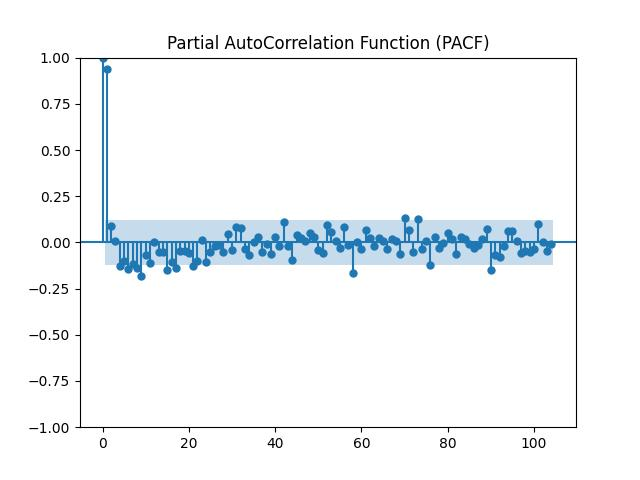

The autocorrelation at lag 0 is always 1, as a series is perfectly correlated with itself. Since we have a high spike at 1 and a drop at 2 we can assume the value p=1 for our non-seasonal parameters might be an appropriate first guess. With no spike at 52, which is the seasonal period we will be choosing for our model, we will assume P=0 for our seasonal parameters.